# Group 14 Analysis
Milestone 1

## Summary


## Introduction:
- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report.
- clearly state the question you tried to answer with your project
- identify and describe the dataset that was used to answer the question


## Methods & Results:
- describe in written english the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
- your report should include code which:
    - loads data from the original source on the web
    - wrangles and cleans the data from it’s original (downloaded) format to the format necessary for the planned classification or clustering analysis
    - performs a summary of the data set that is relevant for exploratory data analysis related to the planned classification analysis
    - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned classification analysis
    - performs classification or regression analysis
    - reates a visualization of the result of the analysis
note: all tables and figure should have a figure/table number and a legend


In [12]:
library(tidyverse)
install.packages("GGally")
library(GGally)
library(purrr)
install.packages("knitr")
library(knitr)
install.packages("tidymodels")
library("tidymodels")
install.packages("leaps")
library(leaps)
install.packages("mltools")
library(mltools)
set.seed(310)


Warning message:
"package 'GGally' is in use and will not be installed"
Warning message:
"package 'knitr' is in use and will not be installed"
Warning message:
"package 'tidymodels' is in use and will not be installed"
Warning message:
"package 'leaps' is in use and will not be installed"
Warning message:
"package 'mltools' is in use and will not be installed"


In [ ]:
install.packages("leaps")

In [3]:
us_covid <- read_csv("data/US.csv")

Rows: 991 Columns: 564
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr   (16): location_key, place_id, wikidata_id, datacommons_id, country_cod...
dbl  (547): aggregation_level, new_confirmed, new_deceased, new_tested, cumu...
date   (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
# select only the necessary columns from the dataframe
us_selected <- us_covid |>
  select(date, search_trends_anxiety, new_persons_vaccinated, new_hospitalized_patients,
         new_confirmed, new_intensive_care_patients) |>
  drop_na()

#inspect first rows of data
head(us_selected)

date,search_trends_anxiety,new_persons_vaccinated,new_hospitalized_patients,new_confirmed,new_intensive_care_patients
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-12-13,8.49,30635,13404,177830,75
2020-12-14,8.93,4534,13547,195630,199
2020-12-15,8.34,45854,16191,197440,265
2020-12-16,7.92,154789,15571,237037,279
2020-12-17,7.70,266820,15247,242528,248
2020-12-18,7.08,409914,15269,233736,231


In [9]:
# summarise all numeric values with 5 number summary + mean
covid_summary <- us_selected %>%
  summarise(across(where(is.numeric), list(
    Min = min,
    Q1 = ~quantile(.x, 0.25),
    Mean = mean,
    Median = median,
    Q3 = ~quantile(.x, 0.75),
    Max = max
  ), .names = "{.col}_{.fn}")) %>%
  pivot_longer(cols = everything(), names_to = c("Variable", "Statistic"), names_sep = "_(?=[^_]+$)") %>%
  pivot_wider(names_from = Statistic, values_from = value)

# summarise all date values with 5 number summary + mean by converting to numernic and then convert back
dates_day<- as.numeric(us_selected$date)
date_summary <- tibble(Variable = c("date"),
                      Min = min(dates_day),
                      Q1 = quantile(dates_day, 0.25),
                      Mean = mean(dates_day),
                      Median = median(dates_day),
                      Q3 = quantile(dates_day, 0.75),
                      Max = max(dates_day)
                      )|>
mutate(across(where(is.numeric), as_date))

table_summary <- rbind(covid_summary,date_summary)

#Count missing values from original dataset
us_missing <- us_covid |>
  select(search_trends_anxiety, new_persons_vaccinated, new_hospitalized_patients,
         new_confirmed, new_intensive_care_patients,date)

us_missing_counts <- tibble(Variable = table_summary$Variable,
                            Observations = colSums(!is.na(us_selected)),
                            Missing = colSums(is.na(us_missing)))

#combine together all summary data
table_summary_final <- inner_join(table_summary, us_missing_counts, by = "Variable")

In [14]:
# print the table in a format ready for markdown
# commented out and pasted into markdown cell below
# kable(table_summary_final)

<h4>Table 1 : Summary statistics of the selected variables</h4>

|Variable                    |     Min|        Q1|         Mean|    Median|         Q3|       Max| Observations| Missing|
|:---------------------------|-------:|---------:|------------:|---------:|----------:|---------:|------------:|-------:|
|search_trends_anxiety       |     5.5|      7.17| 7.736588e+00|      7.79|       8.29|      10.9|           85|       5|
|new_persons_vaccinated      |  4534.0| 371081.00| 7.822666e+05| 798390.00| 1157564.00| 2005480.0|           85|     350|
|new_hospitalized_patients   |  4332.0|   7275.00| 1.159166e+04|  12988.00|   15247.00|   18104.0|           85|      14|
|new_confirmed               | 39828.0|  69225.00| 1.443094e+05| 147277.00|  200308.00|  286196.0|           85|       3|
|new_intensive_care_patients |    22.0|     84.00| 1.418353e+02|    141.00|     186.00|     279.0|           85|     572|
|date                        | 18609.0|  18630.00| 1.865100e+04|  18651.00|   18672.00|   18693.0|           85|       0|

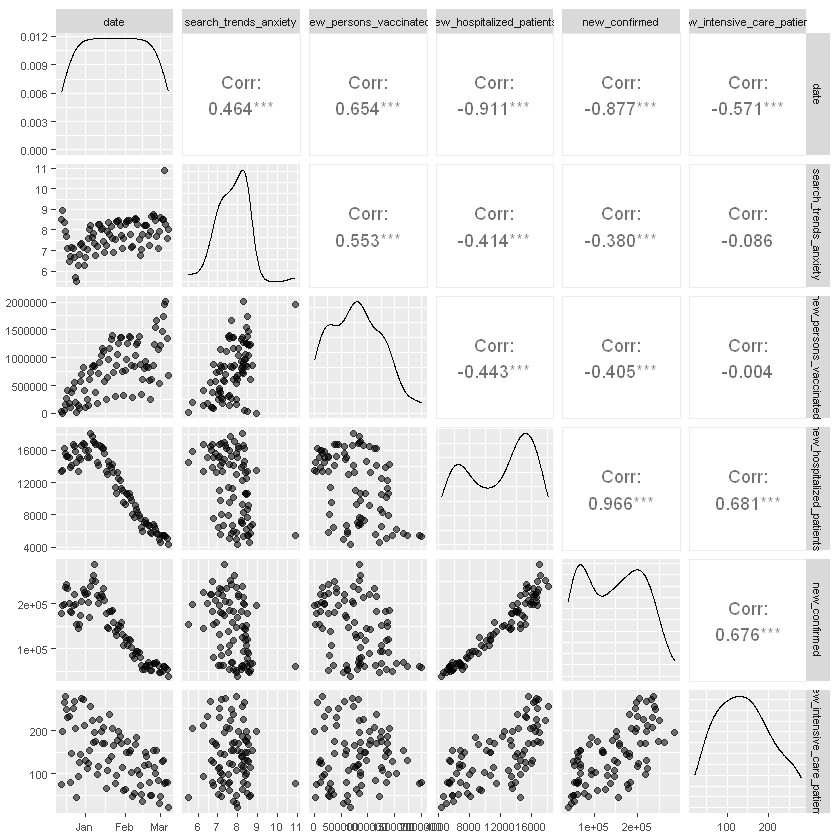

In [16]:
ggpairs(us_selected, aes(alpha = 0.5)) +
    theme(text = element_text(size = 8))

<h4>Figure 1. Exploratory Analysis of Predictors and their Distribution</h4>

Warning message:
"Removed 5 rows containing missing values or values outside the scale range (`geom_line()`)."


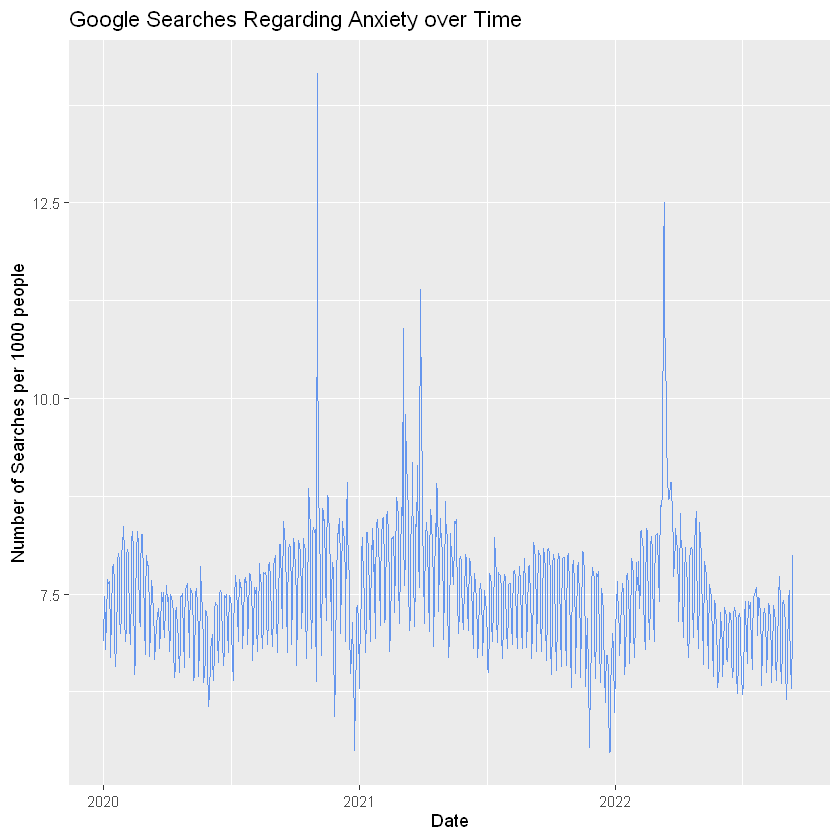

In [17]:
anxiety_time_plot <- ggplot(us_covid, aes(y=search_trends_anxiety, x= date )) +
  geom_line(color = "cornflower blue")+
  labs(title = "Google Searches Regarding Anxiety over Time",
       x = "Date",
       y = "Number of Searches per 1000 people")

anxiety_time_plot

<h4>Figure 2: Time Series plot of the Response Variable</h4>

<h2>Picking the best features:</h2>

In [29]:
# splitting the data:
covid_split <- initial_split(us_selected, prop = 0.75, strata = search_trends_anxiety)
covid_train <- training(covid_split)
covid_test <- testing(covid_split)

# make dates into number of days  
covid_train_numeric <- covid_train|> 
  mutate(date = as.numeric(date))

covid_backward_sel <- regsubsets(
  x = search_trends_anxiety ~ new_persons_vaccinated + 
    new_hospitalized_patients +
    new_confirmed +
    new_intensive_care_patients +
    date, 
  nvmax = 5,
  data = covid_train_numeric,
  method = "backward",
)


In [30]:
# summary of each model's performance

covid_backward_sel_summary <- summary(covid_backward_sel)

covid_backward_sel_summary_df <- data.frame(
  n_input_variables = 1:5,
  RSQ = covid_backward_sel_summary$rsq, 
  RSS = covid_backward_sel_summary$rss,
  ADJ.R2 = covid_backward_sel_summary$adjr2
)

covid_backward_sel_summary_df

n_input_variables,RSQ,RSS,ADJ.R2
<int>,<dbl>,<dbl>,<dbl>
1,0.3527753,28.22384,0.3418054
2,0.4019704,26.07857,0.3813487
3,0.4355578,24.61391,0.4058504
4,0.4390176,24.46304,0.3989474
5,0.4399373,24.42293,0.3890225


<h4>Table 2: RSQ, RSS, and Adjusted R^2 of each model with the number of features used</h4>

In [42]:
# show which variables make up each of the tested models
covid_backward_sel_summary[1]

,(Intercept),new_persons_vaccinated,new_hospitalized_patients,new_confirmed,new_intensive_care_patients,date
1,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE
2,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE
3,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE
4,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE
5,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


<h4>Table 3: The features used in each model tested</h4>

To find the best features to use to predict the google searches for Anxiety, we used backward selection to pick the set of features that would produce the best adjusted R^2 value and therefore give us the model that explained our data the best.  As seen in Table 2, a model with 3 features provides the highest adjusted R^2 value at 0.315. This model is made of the variables new_persons_vaccinated, new_hospitalized_patients, and date.

<h2>Creating the final model</h2>

In [43]:
# create a mulitple linear regression model with the proposed features
final_model <- lm(search_trends_anxiety ~ new_persons_vaccinated + new_hospitalized_patients + date,
   data = covid_train_numeric)

#create a table with the regression results
tidy(final_model)


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.595603e+02,2.203093e+02,0.7242556,0.4718711741
new_persons_vaccinated,9.583246e-07,2.543659e-07,3.7675050,0.0003928682
new_hospitalized_patients,-8.991253e-05,6.074056e-05,-1.4802715,0.1443072501
date,-8.125315e-03,1.178454e-02,-0.6894894,0.4933128160


<h2>Testing the final model</h2>

In [ ]:
# make sure dates are in numeric form as days since 1970-01-01
covid_test_numeric <- covid_test|> 
  mutate(date = as.numeric(date))
# apply the model to predict test data
final_model_predictions <- predict(final_model, newdata = covid_test_numeric)

# find the RMSE between the model's prediction and the actual values
final_model_RMSE = rmse(preds = final_model_predictions,
                      actuals = covid_test_numeric$search_trends_anxiety)
# print the accuracy rate
final_model_RMSE

The model has a RMSE of 0.755 

## Discussion:
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?


## References:
at least 4 citations relevant to the project (format is your choose, just be consistent across the references).